In [ ]:
!pip install -r requirements.txt

**Training**

In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets.folder import default_loader
import torch.nn.functional as F
from torchvision.models import efficientnet_b3
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [76]:
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import shap

In [77]:
# Paths
IMG_DIR = "/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image"
CSV_PATH = "/kaggle/input/isic-2020-jpg-256x256-resized/train-metadata.csv"

In [78]:
# Load metadata
metadata = pd.read_csv(CSV_PATH)

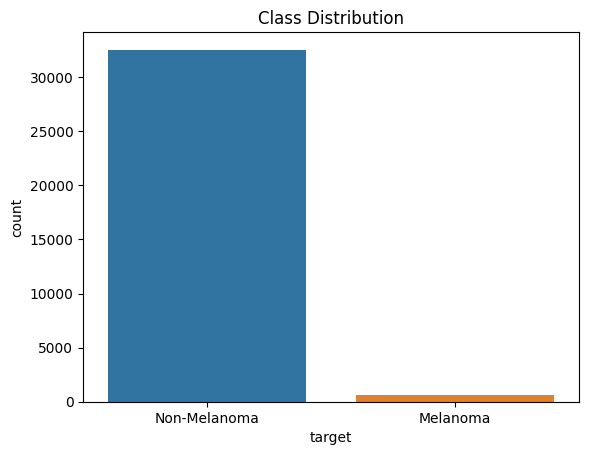

In [79]:
# Visualize class distribution
sns.countplot(data=metadata, x='target')
plt.title("Class Distribution")
plt.xticks([0,1], ['Non-Melanoma', 'Melanoma'])
plt.show()

In [80]:
# Count the number of items in each class
class_counts = metadata['target'].value_counts()
print("Class counts:")
print(f"Non-Melanoma: {class_counts[0]}")
print(f"Melanoma: {class_counts[1]}")

Class counts:
Non-Melanoma: 32542
Melanoma: 584


In [81]:
# Shuffle entire dataset
metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)

# Split classes
melanoma_df = metadata[metadata['target'] == 1]
non_melanoma_df = metadata[metadata['target'] == 0]

# Downsample Non-Melanoma to around 900 samples
non_melanoma_downsampled = non_melanoma_df.sample(n=900, random_state=42)

# Concatenate
balanced_metadata = pd.concat([melanoma_df, non_melanoma_downsampled])

# Final shuffle
balanced_metadata = balanced_metadata.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
balanced_metadata.to_csv("dataset.csv", index=False)

In [82]:
CSV_PATH = "/kaggle/working/dataset.csv"

In [83]:
# Load metadata
metadata = pd.read_csv(CSV_PATH)

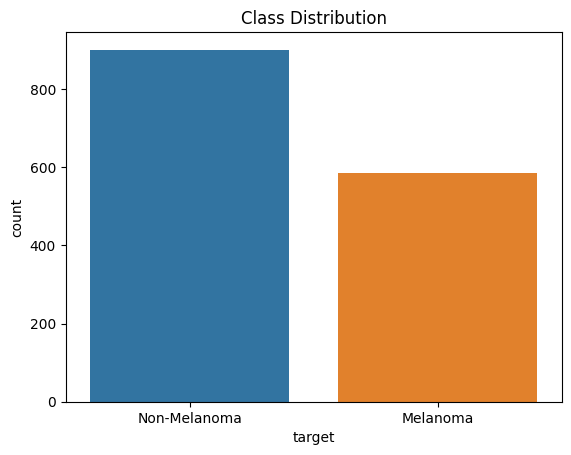

In [84]:
# Visualize class distribution
sns.countplot(data=metadata, x='target')
plt.title("Class Distribution")
plt.xticks([0,1], ['Non-Melanoma', 'Melanoma'])
plt.show()

In [85]:
# Count the number of items in each class
class_counts = metadata['target'].value_counts()
print("Class counts:")
print(f"Non-Melanoma: {class_counts[0]}")
print(f"Melanoma: {class_counts[1]}")

Class counts:
Non-Melanoma: 900
Melanoma: 584


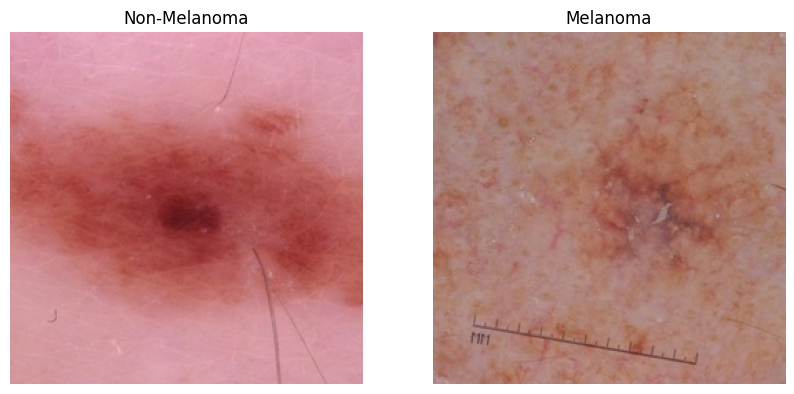

In [86]:
# Plot sample images from each class
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for idx, label in enumerate([0, 1]):
    image_id = metadata[metadata['target'] == label]['isic_id'].iloc[0]
    img_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].set_title('Melanoma' if label == 1 else 'Non-Melanoma')
    axs[idx].axis('off')
plt.show()

In [87]:
# Add full image paths
metadata['path'] = metadata['isic_id'].apply(lambda x: os.path.join(IMG_DIR, f"{x}.jpg"))

In [88]:
# Train, val, test split
train_df, test_df = train_test_split(metadata, test_size=0.1, stratify=metadata['target'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['target'], random_state=42)

In [89]:
train_df.shape

(1201, 5)

In [90]:
val_df.shape

(134, 5)

In [91]:
test_df.shape

(149, 5)

In [92]:
class ISICDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        image = default_loader(image_path)  
        image = np.array(image)            
    
        if self.transform:
            image = self.transform(image=image)['image']
    
        label = torch.tensor(row['target'], dtype=torch.long)
        return image, label


In [93]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.2),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.


In [94]:
# Datasets
train_dataset = ISICDataset(train_df, IMG_DIR, transform=train_transform)
val_dataset = ISICDataset(val_df, IMG_DIR, transform=val_test_transform)
test_dataset = ISICDataset(test_df, IMG_DIR, transform=val_test_transform)

In [95]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [96]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet-B3
model = efficientnet_b3(pretrained=True)

for name, param in model.named_parameters():
    if "features.7" in name or "features.6" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace the classifier head
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.


In [97]:
# Manually set counts
num_non_melanoma = 900
num_melanoma = 584

# Compute weights
total = num_non_melanoma + num_melanoma
weight_non_melanoma = total / (2 * num_non_melanoma)
weight_melanoma = total / (2 * num_melanoma)

# Define weights tensor
class_weights = torch.tensor([weight_non_melanoma, weight_melanoma], dtype=torch.float).to(device)

In [98]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [99]:
# Loss, optimizer, scheduler
criterion = FocalLoss(alpha=class_weights, gamma=2.0)
optimizer = torch.optim.Adam([
    {"params": model.features.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4},
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


In [100]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [126]:
train_losses, val_losses = [], []
train_metrics, val_metrics = [], []
best_val_loss = float('inf')
patience, counter = 5, 0

use_cutmix = True

for epoch in range(20):
    model.train()
    running_loss = 0
    train_preds, train_targets = [], []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        if use_cutmix and np.random.rand() < 0.5:
            lam = np.random.beta(1.0, 1.0)
            rand_index = torch.randperm(images.size()[0]).to(device)
            target_a = labels
            target_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            outputs = model(images)
            loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        targets = labels.detach().cpu().numpy()
        train_preds.extend(preds)
        train_targets.extend(targets)

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_targets, train_preds)
    train_prec = precision_score(train_targets, train_preds, zero_division=0)
    train_rec = recall_score(train_targets, train_preds, zero_division=0)
    train_f1 = f1_score(train_targets, train_preds, zero_division=0)

    model.eval()
    val_running_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = labels.cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(targets)

    val_loss = val_running_loss / len(val_loader)
    val_acc = accuracy_score(val_targets, val_preds)
    val_prec = precision_score(val_targets, val_preds, zero_division=0)
    val_rec = recall_score(val_targets, val_preds, zero_division=0)
    val_f1 = f1_score(val_targets, val_preds, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_metrics.append((train_acc, train_prec, train_rec, train_f1))
    val_metrics.append((val_acc, val_prec, val_rec, val_f1))

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

100%|██████████| 38/38 [00:07<00:00,  5.07it/s]



Epoch 1
Train Loss: 0.1565, Acc: 0.6020, Prec: 0.4964, Recall: 0.8665, F1: 0.6312
Val   Loss: 0.1502, Acc: 0.7239, Prec: 0.6176, Recall: 0.7925, F1: 0.6942


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]



Epoch 2
Train Loss: 0.1507, Acc: 0.6545, Prec: 0.5383, Recall: 0.8496, F1: 0.6590
Val   Loss: 0.1450, Acc: 0.7164, Prec: 0.6000, Recall: 0.8491, F1: 0.7031


100%|██████████| 38/38 [00:07<00:00,  5.04it/s]



Epoch 3
Train Loss: 0.1550, Acc: 0.6261, Prec: 0.5150, Recall: 0.8390, F1: 0.6382
Val   Loss: 0.1520, Acc: 0.7090, Prec: 0.6029, Recall: 0.7736, F1: 0.6777


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]



Epoch 4
Train Loss: 0.1492, Acc: 0.6611, Prec: 0.5437, Recall: 0.8559, F1: 0.6650
Val   Loss: 0.1524, Acc: 0.7015, Prec: 0.5970, Recall: 0.7547, F1: 0.6667


100%|██████████| 38/38 [00:07<00:00,  5.07it/s]



Epoch 5
Train Loss: 0.1489, Acc: 0.6553, Prec: 0.5377, Recall: 0.8771, F1: 0.6667
Val   Loss: 0.1492, Acc: 0.7239, Prec: 0.6176, Recall: 0.7925, F1: 0.6942


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]



Epoch 6
Train Loss: 0.1507, Acc: 0.6328, Prec: 0.5202, Recall: 0.8453, F1: 0.6441
Val   Loss: 0.1479, Acc: 0.7239, Prec: 0.6143, Recall: 0.8113, F1: 0.6992


100%|██████████| 38/38 [00:07<00:00,  5.06it/s]



Epoch 7
Train Loss: 0.1508, Acc: 0.6470, Prec: 0.5312, Recall: 0.8644, F1: 0.6581
Val   Loss: 0.1522, Acc: 0.7164, Prec: 0.6119, Recall: 0.7736, F1: 0.6833
Early stopping triggered!


In [127]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

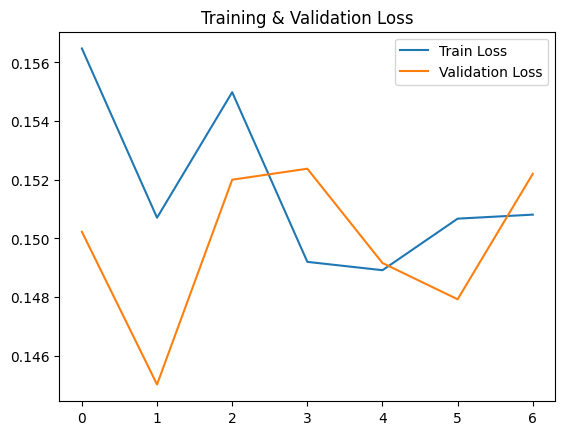

In [128]:
# Plot training curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [129]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

In [130]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7114
Precision: 0.5952
Recall: 0.8475
F1 Score: 0.6993


In [131]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Melanoma", "Melanoma"]))

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.86      0.62      0.72        90
    Melanoma       0.60      0.85      0.70        59

    accuracy                           0.71       149
   macro avg       0.73      0.73      0.71       149
weighted avg       0.76      0.71      0.71       149



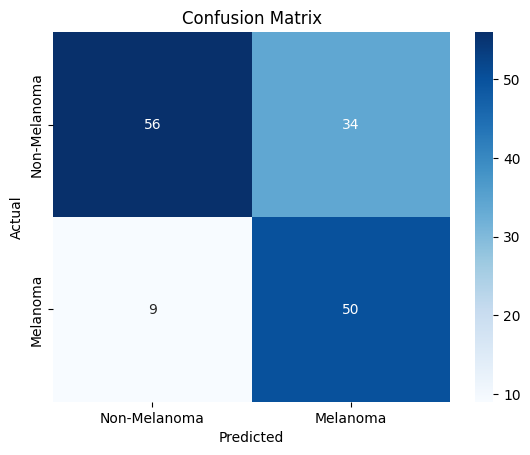

In [132]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Melanoma", "Melanoma"], yticklabels=["Non-Melanoma", "Melanoma"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Explainability**

In [108]:
!pip install grad-cam
!pip install shap

In [153]:
# Define transform
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [134]:
def get_actual_label(image_path, df, class_names=['Non-Melanoma', 'Melanoma']):
    image_id = os.path.splitext(os.path.basename(image_path))[0].strip()
    row = df[df['isic_id'] == image_id]
    if row.empty:
        return None

    target = row.iloc[0]['target']
    label = class_names[int(target)] if class_names else f"Class {target}"
    return label

In [154]:
def generate_gradcam(df, image_path, model, target_layer, device, class_names=['Non-Melanoma', 'Melanoma'], true_label=None):
    model.to(device)
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    transformed = transform(image=image_np)['image'].unsqueeze(0).to(device)
    rgb_image = np.array(image.resize((224, 224))) / 255.0

    # Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    # Prediction
    with torch.no_grad():
        outputs = model(transformed)
        pred_class = outputs.argmax(dim=1).item()
        
    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=transformed, targets=targets)[0]
    cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    predicted_label = class_names[pred_class] if class_names else f"Class {pred_class}"
    actual_label = get_actual_label(image_path, df)

    # Plot original and Grad-CAM images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f"Original: {actual_label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [155]:
def generate_shap(df, image_path, train_loader, model, device, class_names=['Non-Melanoma', 'Melanoma']):
    background_data = []
    model.eval()
    
    for images, _ in train_loader:
        background_data.append(images)
        if len(background_data) * images.shape[0] >= 50:
            break
    
    background = torch.cat(background_data)[:50].to(device)
    image = Image.open(image_path).convert('RGB')
    augmented = transform(image=np.array(image))
    input_tensor = augmented['image'].unsqueeze(0).to(device)
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(input_tensor)

    actual_label = get_actual_label(image_path, df)
    predicted_label = class_names[pred_class] if class_names else f"Class {pred_class}"

    # Unnormalize
    image_np = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np * 0.5) + 0.5
    image_np = np.clip(image_np, 0, 1)
    
    # Extract SHAP values
    shap_map = shap_values[1][0]
    shap_map = np.abs(shap_map).mean(axis=0)
    shap_map = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)
    
    # Resize
    shap_map = cv2.resize(shap_map, (224, 224))
    shap_color = cv2.applyColorMap(np.uint8(255 * shap_map), cv2.COLORMAP_JET)
    shap_color = shap_color[..., ::-1] / 255.0
    
    # Superimpose
    superimposed = (0.5 * image_np + 0.5 * shap_color)
    superimposed = np.clip(superimposed, 0, 1)

    # Plot
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f"Original: {actual_label}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [157]:
PATH = "/kaggle/input/isic-2020-jpg-256x256-resized/train-metadata.csv"
df = pd.read_csv(PATH, encoding='utf-8')

In [164]:
image_path = "/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_0085172.jpg"

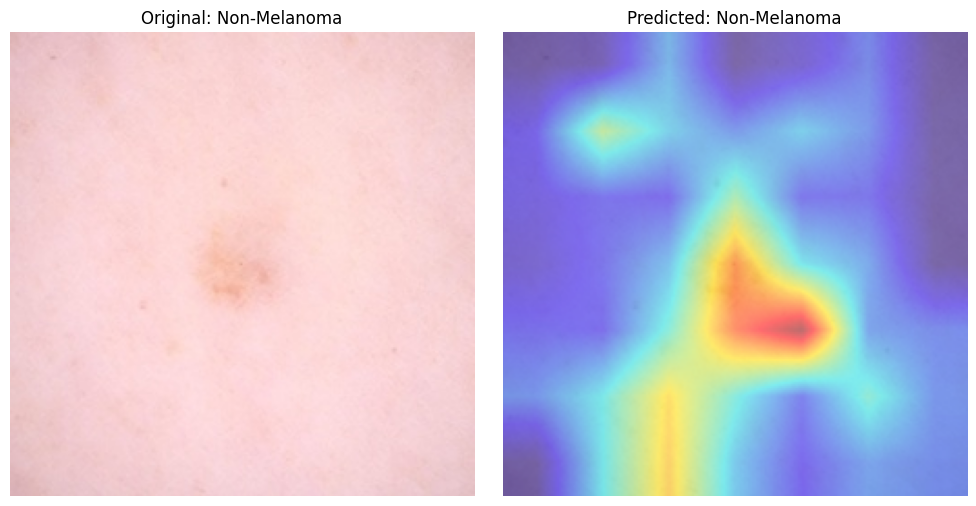

In [165]:
target_layer = model.features[-1]
generate_gradcam(df, image_path, model, target_layer, device)

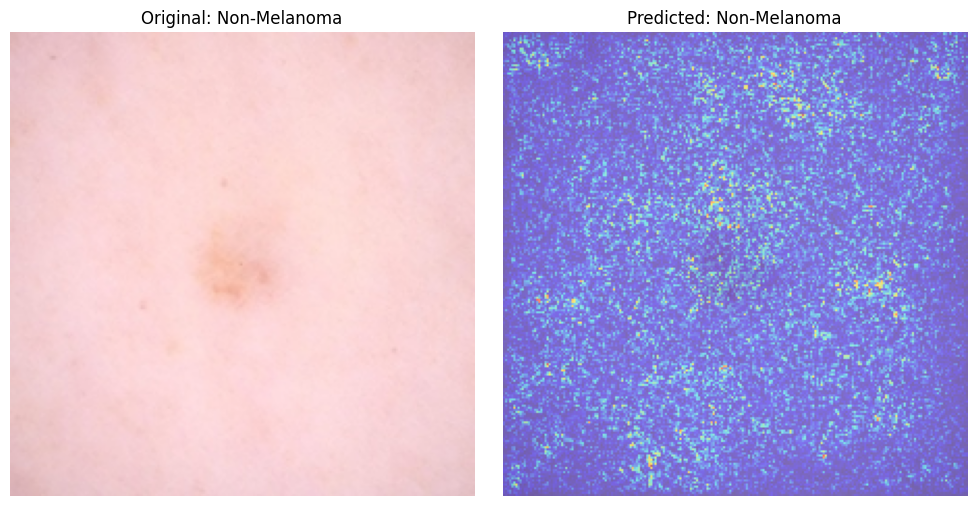

In [166]:
generate_shap(df, image_path, train_loader, model, device)

In [ ]:
plt.savefig("/kaggle/working/shap_cam_comparison.png")
